**INTRODUCTION**

This project focuses on building a medical chatbot using a BERT-based model for sequence classification. The goal is to classify user questions based on medical tags to provide relevant answers.

**BUSINESS PROBLEM**

The business problem is to create a medical chatbot that can accurately classify user questions based on medical tags to provide relevant answers. This is important in the healthcare domain for providing quick and relevant information to users. Natural Language Processing (NLP) is essential here because the input is in the form of natural language text (user questions). NLP techniques allow us to process, understand, and extract meaningful information from this text, enabling the chatbot to classify the questions correctly and provide appropriate responses.

In [ ]:
# Install the evaluate library
%pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.5 MB/s eta 0:00:00


**About the dataset**

https://www.kaggle.com/code/mohsinsial/medical-chatbot/input

short_question: This column stores the user's queries or questions.

Short_answer: These are the responses or answers to the user's queries.

tags: This column contains the relevant tags or keywords associated with each question-answer pair, which provide additional context or information

label: This column shows the label or category of each question-answer pair. A label of 1 usually represents a positive response or affirmation, whereas -1 represents a negative response or rejection.


**Install important libraries**

In [ ]:
#pip install rouge-score sacrebleu evaluate torchsummary

**Import the required libraries**

In [ ]:
import torch
import numpy as np
import pandas as pd
import re
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from datasets import Dataset
from sklearn.model_selection import train_test_split

from torch.nn import CrossEntropyLoss
from torch.optim import AdamW
from torch.utils.data import TensorDataset
from torchsummary import summary

from collections import defaultdict
warnings.filterwarnings("ignore")

**Data Exploration**

In [ ]:
#Loading the dataset
try:
    df = pd.read_csv('/content/sample_data/data_chatbot.csv', engine='python', on_bad_lines='skip')
    print(df.head(1))
except Exception as e:
    print(f"An error occurred while reading the CSV: {e}")

                                      short_question  \
0  can an antibiotic through an iv give you a ras...   

                                        short_answer                   tags  \
0  yes it can even after you have finished the pr...  ['rash' 'antibiotic']   

   label  
0    1.0  


In [ ]:
#Describe the dataset
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5646 entries, 0 to 5645
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   short_question  5646 non-null   object 
 1   short_answer    5434 non-null   object 
 2   tags            5434 non-null   object 
 3   label           5434 non-null   float64
dtypes: float64(1), object(3)
memory usage: 176.6+ KB
None


In [ ]:
#Check the null values
print(df.isnull().sum())

short_question      0
short_answer      212
tags              212
label             212
dtype: int64


In [ ]:
# Drop null values from the DataFrame
df = df.dropna().copy()

# Check for null values after dropping them
print("Number of null values after dropping:")
print(df.isnull().sum())

Number of null values after dropping:
short_question    0
short_answer      0
tags              0
label             0
dtype: int64


In [ ]:
# Check for duplicate rows
#duplicates = df.duplicated()
#print(f"Number of duplicate rows: {duplicates.sum()}")

In [ ]:
df = df.drop_duplicates().copy()

In [ ]:
df = df.drop('label',axis=1)

**Data Cleaning and Preprocessing**

In [ ]:
def lowercase_text(text):
    return str(text).lower()
df = df.applymap(lowercase_text)

In [ ]:
import re

def remove_noise(text):
    text = re.sub(r'<.*?>', '', str(text))
    text = re.sub(r'[^\w\s]', '', text)
    return text
Cleaned_df = df.applymap(remove_noise)

In [ ]:
# Remove stopwords
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
def remove_stopwords(text):
    words = text.split()  # Split text into words
    filtered_words = [word for word in words if word.lower() not in stop_words]  # Remove stopwords
    return ' '.join(filtered_words)  # Join filtered words back into a string

# Apply stopword removal to all columns
processed_df = Cleaned_df.applymap(remove_stopwords)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
processed_df.head(10)

,short_question,short_answer,tags
0,antibiotic iv give rash couple days later,yes even finished prescription antibiotics,rash antibiotic
1,test positive hep b vaccine,test positive hep b vaccine subsequent blood t...,hepatitis b
2,dietary restrictions celiac disease gluten,omitting gluten diet key controlling celiac di...,celiac disease
3,transmit genital warts seventeen years removed,famotidine pepcid products drug class called h...,wart
4,vitamin,hi means hepatitis b immune hepatitis b recomm...,vitamin
5,disabled veteran medicare affected affordable ...,risk developing epilepsy increases family hist...,
6,taking multiple antibiotics cause redness dryn...,fun question glad asked first let set mind eas...,antibiotics
7,stroke brain 2012 2016 cant get 5 hours sleep day,40 generally healthy 50 chance developing seri...,stroke brain
8,pneumonia shot get either sinus infection walk...,always catch illness child viral like colds pn...,pneumonia sinus infection walking
11,baby ate poop baby ate poop 4 days later sick ...,hi one 47 mum never seamed affect say little b...,baby cough fever coldness cold


**Feature Engineering**

In [ ]:
# Tokenization and Stemming
import nltk
from nltk.stem import PorterStemmer
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt_tab') # Download the missing resource
stemmer = PorterStemmer()
def stem_text(text):
    words = nltk.word_tokenize(str(text))  # Tokenize text
    stemmed_words = [stemmer.stem(word) for word in words]  # Stem each word
    return ' '.join(stemmed_words)  # Join stemmed words back into a string
stemmed_df = processed_df.applymap(stem_text)
df = stemmed_df

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
# Check the spelling
from textblob import TextBlob
def spell_check_text(text):
    blob = TextBlob(str(text))
    corrected_text = blob.correct()
    return str(corrected_text)
#df = stemmed_df.applymap(spell_check_text)

**Data Preparation**

In [ ]:
from transformers import BertTokenizerFast
from sklearn.preprocessing import LabelEncoder
from datasets import Dataset
import pandas as pd

# Train-test split
train_df, test_df = train_test_split(df, test_size=0.15, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.15, random_state=42)

# Instantiate the tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

# Apply tokenization to the training and validation dataframes
train_encodings = tokenizer(list(train_df['short_question']), truncation=True, padding=True, max_length=128, return_tensors='pt')
val_encodings = tokenizer(list(val_df['short_question']), truncation=True, padding=True, max_length=128, return_tensors='pt')
test_encodings = tokenizer(list(test_df['short_question']), truncation=True, padding=True, max_length=128, return_tensors='pt')

# Create new columns for tokenized data
train_df['input_ids'] = train_encodings['input_ids'].tolist()
train_df['attention_mask'] = train_encodings['attention_mask'].tolist()
train_df['token_type_ids'] = train_encodings['token_type_ids'].tolist()

val_df['input_ids'] = val_encodings['input_ids'].tolist()
val_df['attention_mask'] = val_encodings['attention_mask'].tolist()
val_df['token_type_ids'] = val_encodings['token_type_ids'].tolist()

test_df['input_ids'] = test_encodings['input_ids'].tolist()
test_df['attention_mask'] = test_encodings['attention_mask'].tolist()
test_df['token_type_ids'] = test_encodings['token_type_ids'].tolist()

# Instantiate and fit LabelEncoder on combined labels
le = LabelEncoder()
le.fit(pd.concat([train_df['tags'], val_df['tags'], test_df['tags']],axis=0))

# Transform labels
train_df['labels'] = le.transform(train_df['tags'])
val_df['labels'] = le.transform(val_df['tags'])
test_df['labels'] = le.transform(test_df['tags'])

# Convert dataframes to Dataset objects
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

# Select relevant columns for the Dataset objects
train_dataset = train_dataset.remove_columns(['short_question', 'short_answer', 'tags', '__index_level_0__'])
val_dataset = val_dataset.remove_columns(['short_question', 'short_answer', 'tags', '__index_level_0__'])
test_dataset = test_dataset.remove_columns(['short_question', 'short_answer', 'tags', '__index_level_0__'])

print("Training Dataset:")
print(train_dataset)
print("\nValidation Dataset:")
print(val_dataset)
print("\nTest Dataset:")
print(test_dataset)

Training Dataset:
Dataset({
    features: ['input_ids', 'attention_mask', 'token_type_ids', 'labels'],
    num_rows: 3925
})

Validation Dataset:
Dataset({
    features: ['input_ids', 'attention_mask', 'token_type_ids', 'labels'],
    num_rows: 693
})

Test Dataset:
Dataset({
    features: ['input_ids', 'attention_mask', 'token_type_ids', 'labels'],
    num_rows: 816
})


**MODEL TRAINING AND EVALUATION**

BERT model for sequence classification by importing the necessary class, determining the number of labels, and instantiating the model.



In [ ]:
from transformers import BertForSequenceClassification

# Get the number of unique tags to define the number of output labels for the model
num_labels = len(le.classes_)

# Define the BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)

# Move model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_strategy="steps",
    logging_steps=500,
    eval_strategy="steps",
    eval_steps=500,
    save_strategy="steps",
    save_steps=500,
)

In [ ]:
# Import the `Trainer` class and define a `compute_metrics` function for evaluation
from transformers import Trainer
from sklearn.metrics import accuracy_score, f1_score
from evaluate import load
import nltk

# Download necessary NLTK data
try:
    nltk.data.find('tokenizers/punkt')
except nltk.downloader.DownloadError:
    nltk.download('punkt')
except nltk.downloader.NLTKDataURLException:
     nltk.download('punkt')


# Load the evaluation metrics
rouge_metric = load("rouge")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    # Decode labels and predictions for ROUGE
    decoded_predictions = le.inverse_transform(predictions)
    decoded_labels = le.inverse_transform(labels)

    # Calculate Accuracy and F1 Score
    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='weighted')  # Used weighted average for multi-class

    # Calculate ROUGE score
    rouge_score = rouge_metric.compute(predictions=decoded_predictions, references=decoded_labels)
    return {
        "accuracy": accuracy,
        "f1": f1,
        "ROUGE-L": rouge_score["rougeL"],
    }

In [ ]:
# Instantiate the `Trainer` object with the defined model, training arguments, datasets, and the `compute_metrics` function.
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

In [ ]:
#Start the training process using the trainer.train() method.
log_history = trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: dhivya781 (dhivya781-ssp-worldwide-india-pvt-ltd) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: WARNING Serializing object of type dict that is 147544 bytes
wandb: WARNING Serializing object of type dict that is 103856 bytes


Step,Training Loss,Validation Loss,Accuracy,F1,Rouge-l
500,7.627000,8.127283,0.103896,0.021426,0.002391
1000,6.777300,8.009645,0.106782,0.030252,0.065294
1500,6.025900,8.060651,0.113997,0.049569,0.103803
2000,5.568500,8.025700,0.125541,0.061209,0.123004


In [ ]:
eval_results = trainer.evaluate()
print(eval_results)

{'eval_loss': 8.020418167114258, 'eval_accuracy': 0.12554112554112554, 'eval_f1': 0.061555742527990225, 'eval_ROUGE-L': 0.1269351900304282, 'eval_runtime': 4.5849, 'eval_samples_per_second': 151.148, 'eval_steps_per_second': 9.597, 'epoch': 10.0}


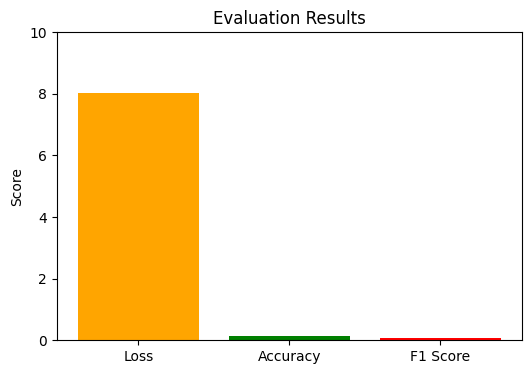

In [ ]:
# Plot the evaluation results
eval_loss = eval_results['eval_loss']
eval_accuracy = eval_results['eval_accuracy']
eval_f1 = eval_results['eval_f1']

metrics = ['Loss', 'Accuracy', 'F1 Score']
values = [eval_loss, eval_accuracy, eval_f1]

plt.figure(figsize=(6, 4))
plt.bar(metrics, values, color=['orange', 'green', 'red'])
plt.ylabel('Score')
plt.title('Evaluation Results')
plt.ylim(0, 10)
plt.show()

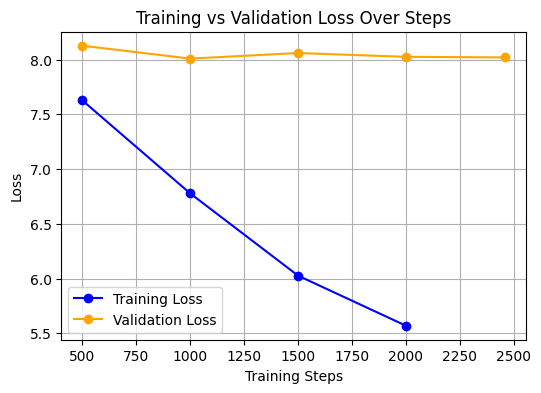

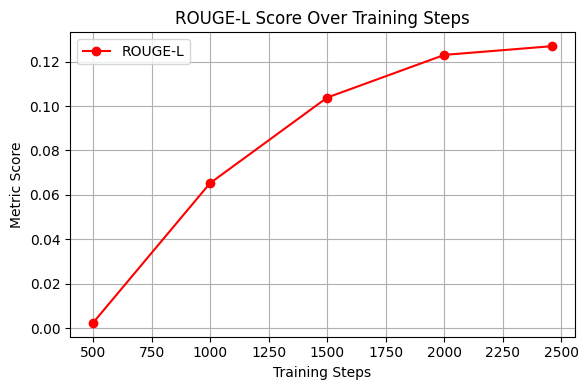

In [ ]:
# Extract loss values and metrics from log history
train_loss = []
eval_loss = []
eval_rouge_l = []
steps = []
eval_steps = []

for log in trainer.state.log_history:
    if "loss" in log and "step" in log:
        # Training loss logs don't have "eval_" prefix
        if "eval_loss" not in log:
             train_loss.append(log["loss"])
             steps.append(log["step"])
    if "eval_loss" in log and "step" in log:
        eval_loss.append(log["eval_loss"])
        eval_steps.append(log["step"])
    if "eval_ROUGE-L" in log and "step" in log: # Using ROUGE-L
        eval_rouge_l.append(log["eval_ROUGE-L"])


# Plot the losses
plt.figure(figsize=(6, 4))
plt.plot(steps, train_loss, label="Training Loss", color="blue", marker="o")
# Ensure eval_steps aligns with eval_loss
if eval_steps and eval_loss:
    plt.plot(eval_steps, eval_loss, label="Validation Loss", color="orange", marker="o")
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss Over Steps")
plt.legend()
plt.grid(True)
plt.show()

# Plot the ROUGE-L scores
if eval_steps and eval_rouge_l: # Only plot if there are ROUGE-L scores
    plt.figure(figsize=(6, 4))
    plt.plot(eval_steps[:len(eval_rouge_l)], eval_rouge_l, label="ROUGE-L", marker="o", linestyle="-", color="red")
    plt.xlabel("Training Steps")
    plt.ylabel("Metric Score")
    plt.title("ROUGE-L Score Over Training Steps")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
     print("No ROUGE-L scores logged to plot.")

In [ ]:
trainer.save_model("./bert_chatbot_model")
tokenizer.save_pretrained("./bert_chatbot_tokenizer")

('./bert_chatbot_tokenizer/tokenizer_config.json',
 './bert_chatbot_tokenizer/special_tokens_map.json',
 './bert_chatbot_tokenizer/vocab.txt',
 './bert_chatbot_tokenizer/added_tokens.json',
 './bert_chatbot_tokenizer/tokenizer.json')

In [ ]:
# Test the model with the validation dataset
from torch.utils.data import DataLoader
import torch
import numpy as np # Import numpy
from sklearn.metrics import accuracy_score, f1_score
from evaluate import load
import nltk

# Create a DataLoader for the test dataset
# Use a smaller batch size for inference if needed
val_dataloader = DataLoader(test_dataset, batch_size=16)

# Set the model to evaluation mode
model.eval()

# Move model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

predictions = []
true_labels = []

# Iterate over the validation data for prediction
for batch in val_dataloader:
    # Move batch to the appropriate device
    # Convert list of tensors to a single tensor before moving to device
    # Remove 'labels' from the batch as they are not needed for inference
    labels = batch.pop('labels').cpu().numpy() # Store true labels before popping
    batch = {k: torch.stack(v).to(device) if isinstance(v, list) else v.to(device) for k, v in batch.items()}
    with torch.no_grad():  # Disable gradient calculation
        outputs = model(**batch)

    # Get the predicted tag index
    logits = outputs.logits
    predicted_indices = torch.argmax(logits, dim=-1).cpu().numpy()
    predictions.extend(predicted_indices)

    # Get the true labels (from the popped labels)
    true_labels.extend(labels)

# Decode the predicted indices back to original tags using the LabelEncoder
predicted_tags = le.inverse_transform(predictions)
true_tags = le.inverse_transform(true_labels)

# Display some of the results
print("\nSample Predictions vs True Labels:")
for i in range(min(10, len(predicted_tags))): # Displaying first 10 predictions
    print(f"Predicted: {predicted_tags[i]}, True: {true_tags[i]}")



Sample Predictions vs True Labels:
Predicted: , True: pelvi peni prostat
Predicted: , True: chlamydia
Predicted: exercis, True: skin stomach exercis diet weight loss
Predicted: period pregnanc pain back pain, True: chronic pain shoulder
Predicted: , True: osteoporosi
Predicted: period pregnanc pain back pain, True: syncop symptom
Predicted: pregnanc, True: urin
Predicted: , True: chlamydia
Predicted: , True: mammogram lump breast ultrasound period
Predicted: exercis, True: tendon exercis


**Key Findings:**

*   **Evaluation Metrics:**
    *   The model achieved an accuracy of approximately 12.55%.
    *   The weighted F1-score is around 6.16%.
    *   The ROUGE-L score is about 12.69%.

*   **Loss Over Training Steps:**
    *   The training loss generally decreases over the training steps.
    *   The validation loss shows fluctuations but also a general decreasing trend, although it is higher than the training loss, suggesting potential overfitting.

*   **ROUGE-L Score Over Training Steps:**
    *   The ROUGE-L score on the validation set shows some improvement over the training steps, indicating that the model is learning to generate more relevant tags.

*   **Sample Predictions:**
    *   The sample predictions show that the model is often predicting an empty string or incorrect tags compared to the true labels. This aligns with the low accuracy and F1-score.

**Overall:**

The model shows some signs of learning as indicated by the decreasing loss and increasing ROUGE-L score, but the overall performance, as measured by accuracy and F1-score, is quite low. This suggests that the model is not effectively classifying the `short_question` to the correct `tags`. Further model tuning, data augmentation, or exploring different model architectures might be necessary to improve performance.

**RECOMMENDATIONS**

Based on the key findings, here are some recommendations to potentially improve the model's performance:

*   **Hyperparameter Tuning:** Experiment with different hyperparameters for the `TrainingArguments`, such as learning rate, batch size, and number of epochs.
*   **Data Augmentation:** Since the model is struggling to classify to the correct tags, consider techniques to augment the training data, especially for underrepresented tags.
*   **Explore Different Model Architectures:** While BERT is a strong baseline, other transformer models or even different types of neural network architectures might be more suitable for this specific task.
*   **Refine Data Preprocessing:** Revisit the data cleaning and preprocessing steps. Further analysis of the `tags` column might reveal inconsistencies or areas for improvement in how tags are handled.
*   **Increase Dataset Size:** If feasible, acquiring more labeled data could significantly improve the model's ability to generalize but training them uder larger GPU is the challenge here


**REFERENCES**

raphaelhanley (2024). Chatbot Bangkit. [online] Kaggle.com. Available at: https://www.kaggle.com/code/raphaelhanley/chatbot-bangkit#Architecting-Model [Accessed 2 Jul. 2025].

Lee, J., Yoon, W., Kim, S., Kim, D., Kim, S., So, C.H. and Kang, J. (2019). BioBERT: a pre-trained biomedical language representation model for biomedical text mining. Bioinformatics, [online] 36(4). doi:https://doi.org/10.1093/bioinformatics/btz682.

‌
mohsinsial (2024). Medical Chatbot. [online] Kaggle.com. Available at: https://www.kaggle.com/code/mohsinsial/medical-chatbot [Accessed 2 Jul. 2025].

‌Kaggle.com. (2025). Blocked. [online] Available at: https://www.kaggle.com/code/pythonafroz/automodelforquestionanswering-medical-insights/notebook [Accessed 2 Jul. 2025].
‌

In [ ]:
!ls /content/

Medical_Chatbot_NLP_Project.ipynb  sample_data
